<a href="https://colab.research.google.com/github/joaquinhojman/ArbolesDeDecision/blob/main/XGBoost_with_RandomSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import log_loss
import pandas as pd
import datetime as dt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from urllib.request import urlretrieve


from sklearn.model_selection import train_test_split

In [91]:
url_train = 'https://raw.githubusercontent.com/SantiagoTadini/TP2-Datos/main/Features/data_train.csv'
url_test = 'https://raw.githubusercontent.com/SantiagoTadini/TP2-Datos/main/Features/data_test.csv'
url_test_kaggle = 'https://raw.githubusercontent.com/SantiagoTadini/TP2-Datos/main/Features/data_test_kaggle.csv'

data_train = pd.read_csv(url_train)
data_test = pd.read_csv(url_test)
data_test_kaggle = pd.read_csv(url_test_kaggle)

In [129]:
# Separamos los set de datos (data_train y data_test) de sus columnas 'Target'
# 'x' son los datos, 'y' es el target:
#   --> x_train son los datos con los que entrenar
#   --> y_train son las soluciones con las que comparar lo entrenado con x_train
#   --> x_test son los datos con los que probar
#   --> y_test son las soluciones con las que comparar lo probado con x_test
x_train = data_train.iloc[:, :-1]
y_train = data_train.iloc[:, -1]
x_test = data_test.iloc[:, :-1]
y_test = data_test.iloc[:, -1]
#Esto lo hizo chechu y esta bien, no cambiar.

In [196]:
 xg_reg = xgb.XGBRegressor(colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5 , 
                           alpha = 10, n_estimators = 30, eta=0.2,nthread=2,objective='reg:logistic',
                           booster='gbtree',max_features=12,error='log_loss')
 xg_reg.fit(x_train, y_train)
 preds = xg_reg.predict(x_test) 


In [197]:
error = log_loss(y_test, preds)
error

0.499468301211706

In [95]:
preds_train = xg_reg.predict(x_train)
error_train = log_loss(y_train, preds_train)
error_train

0.28112604813357955

#K-fold cross validation

In [96]:
data_dmatrix = xgb.DMatrix(data=x_train,label=y_train)

In [97]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,
          'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=123)

In [98]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.476458,0.000393,0.476884,0.000513
1,0.457211,0.001626,0.458554,0.003105
2,0.442539,0.001326,0.444240,0.000990
3,0.427632,0.002853,0.429669,0.001671
4,0.414394,0.002053,0.416721,0.003267


In [99]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.282837
Name: test-rmse-mean, dtype: float64


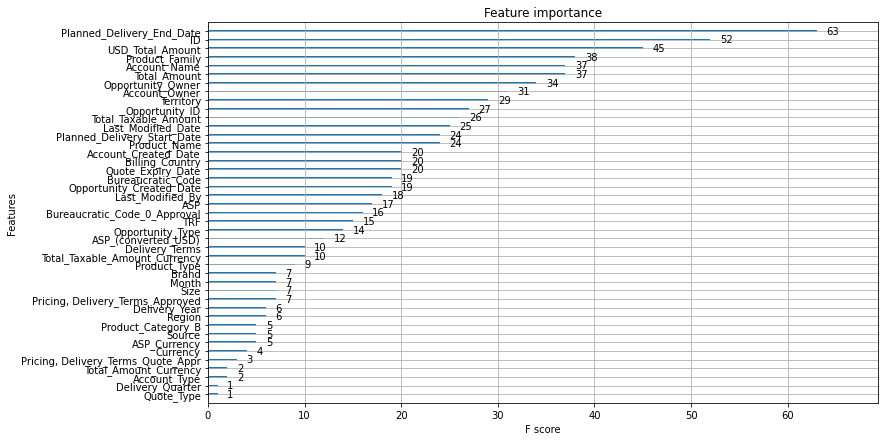

In [100]:
## Importancia de los features (cuantas veces aparecen en los árboles)
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)

##PREDICCIONES

In [101]:
# Sacamos el y_test_de_practica_agrupado_por_opp
oportunidades_test_de_practica = x_test['Opportunity_ID']
oportunidades_test_de_practica = oportunidades_test_de_practica.to_frame()

stage_test_de_practica = y_test.to_frame()

oportunidades_test_de_practica['Target'] = stage_test_de_practica
y_test_agrupado_por_opp = oportunidades_test_de_practica.groupby('Opportunity_ID').agg({'Target' : 'mean'})
y_test_agrupado_por_opp = y_test_agrupado_por_opp.reset_index()

In [102]:
# Sacamos el preds_agrupado_por_opp
oportunidades_test_de_practica = x_test['Opportunity_ID']
oportunidades_test_de_practica = oportunidades_test_de_practica.to_frame()

oportunidades_test_de_practica['Target'] = preds

preds_agrupado_por_opp = oportunidades_test_de_practica.groupby('Opportunity_ID').agg({'Target' : 'mean'})
preds_agrupado_por_opp = preds_agrupado_por_opp.reset_index()

In [103]:
# Calculamos el error con groupby hecho
error = log_loss(y_test_agrupado_por_opp['Target'], np.nan_to_num(preds_agrupado_por_opp['Target'].to_numpy()))
error

0.5038236021392735

In [108]:
# Sacamos el preds_test_agrupado_por_opp

preds_test_kaggle = xg_reg.predict(data_test_kaggle)

oportunidades_test = data_test_kaggle['Opportunity_ID']
oportunidades_test = oportunidades_test.to_frame()

oportunidades_test['Target'] = preds_test_kaggle

preds_test_kaggle_agrupado_por_opp = oportunidades_test.groupby('Opportunity_ID').agg({'Target' : 'mean'})
preds_test_kaggle_agrupado_por_opp = preds_test_kaggle_agrupado_por_opp.reset_index()

preds_test_kaggle_agrupado_por_opp

,Opportunity_ID,Target
0,10689,0.479465
1,10690,0.423327
2,10691,0.201926
3,10692,0.344482
4,10693,0.497590
...,...,...
1562,12364,0.545757
1563,12365,0.189245
1564,12366,0.115730
1565,12367,0.148630


In [ ]:
from google.colab import files

preds_test_agrupado_por_oppGV.to_csv('preds_testxgb.csv', index=False, header=True)
files.download('preds_testxgb.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Optimizacion de hiperparametros

Grid Search for Regression


In [221]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


In [228]:
# Espacio de hiperparámetros

search_space = {
                'alpha' : [8,10,12,14,15,16,16,18,19,20],
                'max_depth' : [4,5,6,7,8,9,10],
                'max_features' : [10, 12, 14,16,18,19,21,20],
                'min_samples_split' : [2, 50,75,100,125,150,175, 200],
                'learning_rate' : [0.001,0.01,0.05,0.1,0.5,1]}
opt = RandomizedSearchCV(estimator=xg_reg, error_score='log_loss', param_distributions=search_space, n_iter = 100)

In [190]:
opt

RandomizedSearchCV(cv=None, error_score='log_loss',
                   estimator=XGBRegressor(alpha=10, base_score=0.5,
                                          booster='gbtree', colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=0.3,
                                          error='log_loss', eta=0.2, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, max_features=12,
                                          min_child_weight=1, missing=None,
                                          n_estimators=30, n_jobs=1, nthread=2,
                                          objective='reg:logistic',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
       

In [191]:
opt.fit(x_train, y_train)
print(opt.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=100. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


{'max_depth': 9}


In [224]:
 xg_reg_optimizado = xgb.XGBRegressor(colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 9, 
                           alpha = 10, n_estimators = 30, eta=0.2,nthread=2,objective='reg:logistic',
                           booster='gbtree',max_features=14,error='log_loss',min_samples_split=100)
 xg_reg_optimizado.fit(x_train, y_train)
 preds_optimizadas = xg_reg_optimizado.predict(x_test) 


In [225]:
error = log_loss(y_test, preds_optimizadas)
error

0.49310927916607117

In [74]:
# Sacamos el y_test_de_practica_agrupado_por_opp
oportunidades_test_de_practica = x_test['Opportunity_ID']
oportunidades_test_de_practica = oportunidades_test_de_practica.to_frame()

stage_test_de_practica = y_test.to_frame()

oportunidades_test_de_practica['Target'] = stage_test_de_practica
y_test_agrupado_por_opp = oportunidades_test_de_practica.groupby('Opportunity_ID').agg({'Target' : 'mean'})
y_test_agrupado_por_opp = y_test_agrupado_por_opp.reset_index()

In [211]:
# Sacamos el preds_agrupado_por_opp
oportunidades_test_de_practica = x_test['Opportunity_ID']
oportunidades_test_de_practica = oportunidades_test_de_practica.to_frame()

oportunidades_test_de_practica['Target'] = preds_optimizadas

preds_agrupado_por_opp = oportunidades_test_de_practica.groupby('Opportunity_ID').agg({'Target' : 'mean'})
preds_agrupado_por_opp = preds_agrupado_por_opp.reset_index()

In [212]:
# Calculamos el error con groupby hecho
error = log_loss(y_test_agrupado_por_opp['Target'], np.nan_to_num(preds_agrupado_por_opp['Target'].to_numpy()))
error

0.49684343257570684

In [213]:
# Sacamos el preds_test_agrupado_por_opp
preds_test_kaggle = xg_reg_optimizado.predict(data_test_kaggle)

oportunidades_test = data_test_kaggle['Opportunity_ID']
oportunidades_test = oportunidades_test.to_frame()

oportunidades_test['Target'] = preds_test_kaggle

preds_test_kaggle_agrupado_por_opp = oportunidades_test.groupby('Opportunity_ID').agg({'Target' : 'mean'})
preds_test_kaggle_agrupado_por_opp = preds_test_kaggle_agrupado_por_opp.reset_index()

preds_test_kaggle_agrupado_por_opp

,Opportunity_ID,Target
0,10689,0.381261
1,10690,0.314539
2,10691,0.161561
3,10692,0.349053
4,10693,0.417359
...,...,...
1562,12364,0.477994
1563,12365,0.134094
1564,12366,0.105533
1565,12367,0.090524


In [214]:
from google.colab import files

preds_test_kaggle_agrupado_por_opp.to_csv('preds_testxgb.csv', index=False, header=True)
files.download('preds_testxgb.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>